# LASSO Regression

In [47]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

import matplotlib.pyplot as plt
import seaborn as sns

from dmba import regressionSummary
%matplotlib inline

## Overview

The Lasso is a shrinkage and selection method for linear regression. It minimizes the usual sum of squared errors, with a bound on the sum of the absolute values of the coefficients. 

It includes a "penalty" that is based on aggregation of coefficient values. Standardizing the variable is important in this method, as this will prepare your data for wrangling and will allow you to draw clearer conclusions.

In this chapter we will provide an example of how to implement LASSO. This is a feature selection method that shrinks our coefficient estimates ($\hat{\beta}_i$s) towards zero, even setting some to be 0. This helps us create an easier-to-interpret model and reduces the risk of overfitting. (Recall, overfitting my model means I've made a model that fits too closely to the training data but isn't generalizable to other data - therefore, it won't make good predictions.)

We'll implement LASSO using our beloved Toyota Corolla dataset. In the MLR notebook, we learned how to use MLR to make predictions about the price a used Toyota Corolla would sell for based on car features. In this notebook, we'll learn how to use LASSO to make those predictions. 

### Toyota Corollas Data
This data represents the sale of used Toyota Corollas in the Netherlands, and our mission is to **predict the price of a car based on its options and features**. 

Below, we show descriptions of some of the variables in our dataset.

| Variable   | Description                           |
|------------|---------------------------------------|
| Price      | Offer price in Euros                  |
| Age        | Age in months as of August 2004       |
| Kilometers | Accumulated Kilometers on odometer    |
| Fuel type  | Fuel type (Petrol, Diesel, CNG)       |
| HP         | Horsepower                            |
| Metallic   | Metallic color (Yes = 1, No= 0)       |
| Automatic  | Automatic (Yes = 1, No = 0)           |
| CC         | Cylinder volume in cubic centimeters  |
| Doors      | Number of doors                       |
| QuartTax   | Quarterly road tax in Euros           |
| Weight     | Weight in Kilograms                   |

## Data Processing

Read the data using the ```read_csv``` function from pandas package and save it as the dataframe `car_df`. The data is called `'ToyotaCorolla.csv'`. Use the `.head()` method to make sure the dataframe has been created correctly.

In [2]:
car_df = pd.read_csv('ToyotaCorolla.csv')
car_df.head()

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,...,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,...,1,1,0,0,0,1,0,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,...,0,1,0,0,0,1,0,0,0,0
2,3,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,...,0,1,0,0,0,1,0,0,0,0
3,4,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,14950,26,7,2002,48000,Diesel,90,0,...,0,1,0,0,0,1,0,0,0,0
4,5,TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors,13750,30,3,2002,38500,Diesel,90,0,...,1,1,0,1,0,1,0,0,0,0


We use the map function to iterate through a list of values (in this case, the column names, and apply a function to each item in the list. In this case, we want make each item lowercase.)

In [3]:
car_df.columns = map(str.lower, car_df.columns)
car_df.columns

Index(['id', 'model', 'price', 'age_08_04', 'mfg_month', 'mfg_year', 'km',
       'fuel_type', 'hp', 'met_color', 'color', 'automatic', 'cc', 'doors',
       'cylinders', 'gears', 'quarterly_tax', 'weight', 'mfr_guarantee',
       'bovag_guarantee', 'guarantee_period', 'abs', 'airbag_1', 'airbag_2',
       'airco', 'automatic_airco', 'boardcomputer', 'cd_player',
       'central_lock', 'powered_windows', 'power_steering', 'radio',
       'mistlamps', 'sport_model', 'backseat_divider', 'metallic_rim',
       'radio_cassette', 'parking_assistant', 'tow_bar'],
      dtype='object')

We can see that `id` and `model` aren't useful to include, as `id` provides a unique but meaningless number for each row, and model is not important, as these are all Toyota Corollas. Let's drop those. 

In [2]:
car_df=car_df.drop(columns =['model','id']) 
car_df.columns

Recall that we have to convert categorical variables to numbers. We only have nominal (unordered) categorical variables, so they should be converted to a set of dummy variables. 

We've already dropped `model`, so our two remaining categorical variables are `color` and `fuel_type`.

We use `pd.get_dummies`  to dummy-code all the variables. Each categorical variable will generate two or more dummy variables. Dropping the first dummy variable  (using the argument `drop_first`) ensures we won't have problems with perfect multicollinearity.

In [9]:
car_df = pd.get_dummies(car_df, drop_first=True)
car_df.columns

Index(['price', 'age_08_04', 'mfg_month', 'mfg_year', 'km', 'hp', 'met_color',
       'automatic', 'cc', 'doors', 'cylinders', 'gears', 'quarterly_tax',
       'weight', 'mfr_guarantee', 'bovag_guarantee', 'guarantee_period', 'abs',
       'airbag_1', 'airbag_2', 'airco', 'automatic_airco', 'boardcomputer',
       'cd_player', 'central_lock', 'powered_windows', 'power_steering',
       'radio', 'mistlamps', 'sport_model', 'backseat_divider', 'metallic_rim',
       'radio_cassette', 'parking_assistant', 'tow_bar', 'fuel_type_Diesel',
       'fuel_type_Petrol', 'color_Black', 'color_Blue', 'color_Green',
       'color_Grey', 'color_Red', 'color_Silver', 'color_Violet',
       'color_White', 'color_Yellow'],
      dtype='object')

Let's use bracket notation with the new column names to again select the first three rows. What do we see? The first car (row index equal to 0) had a blue car that used diesel. We see below that fuel_type_Diesel = 1, color_Blue = 1, and all the other dummy variables are equal to 0.

For a car with fuel type CNG, what would fuel_type_Diesel and fuel_type_Petrol equal?

How would I know from these new dummy variables that a car is Beige?

In [1]:
car_df[['fuel_type_Diesel', 'fuel_type_Petrol', 'color_Black', 'color_Blue', 'color_Green',
       'color_Grey', 'color_Red', 'color_Silver', 'color_Violet',
       'color_White', 'color_Yellow']].head(3)

SyntaxError: invalid syntax (<ipython-input-1-fe851e3eb291>, line 5)

---

## Model Building

Now, we can finally move on to what we're really interested in - using a regularization technique called LASSO to help us decide which predictors we should include in our model.

Let's define our predictors and outcome variable. **Lasso will help me determine which, if any, predictor variables I should drop.** 

We'll then create the training and test sets, using our `X` and `y` objects.

In [22]:
outcome = 'price'
predictors = ['age_08_04', 'km', 'fuel_type_Petrol', 'fuel_type_Diesel', 'hp', 'met_color', 'automatic', 'cc', 'doors', 'quarterly_tax', 'weight']

X = car_df[predictors] 
y = car_df[outcome] 

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1) 
train_X

,age_08_04,km,fuel_type_Petrol,fuel_type_Diesel,hp,met_color,automatic,cc,doors,quarterly_tax,weight
1238,75,82256,1,0,110,1,0,1600,3,69,1050
1085,79,131500,0,1,72,0,0,2000,5,185,1140
680,61,102106,1,0,110,0,0,1600,3,69,1050
593,50,22648,1,0,97,1,0,1400,5,85,1060
647,68,117000,0,1,72,0,0,2000,3,185,1115
...,...,...,...,...,...,...,...,...,...,...,...
715,62,90000,1,0,110,0,0,1600,3,69,1050
905,65,59000,1,0,110,0,0,1600,3,69,1050
1096,75,125400,1,0,110,0,0,1600,3,69,1050
235,38,60829,1,0,110,1,0,1600,5,85,1075


Remember that in a LASSO model, we penalize large coefficient estimates. The magnitude of a coefficient estimate can vary depending on the units of the variable. We address this by standardizing our data.

In [23]:
#Standardization

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_X=scaler.fit_transform(train_X)
valid_X=scaler.transform(valid_X)

Fitting a LASSO model is very similar to fitting an MLR model, except we'll need to specify the penalty parameter, $\lambda$. Somewhat confusingly, we specify $\lambda$ in the `alpha` argument in the LASSO function. (LASSO is an algorithm in the scikit learn package.)

We need to take the following steps.
1. Choose a value for $\lambda$ (the penalty parameter). Below, we set it to equal 1.
2. Initialize the LASSO algorithm, setting the $\lambda$ value (alpha argument)
3. Fit the model using the training data (this finds the best coefficients AKA the $\hat{\beta}_i$s)
4. Use the results (that is, use the coefficient estimates) from the fitted model to predict the outcome (price) for the validation data

In [24]:
# Step 1: Set lambda
lambda_val = 1

# Step 2: load the lasso regression algorithm into an object called "car_lasso"
car_lasso = Lasso(alpha = lambda_val)

# Step 3: fit the lasso model using the training data
car_lasso.fit(train_X, train_y)

# Step 4 use the fitted model to predict the outcome for the validation data
car_lasso_predict = car_lasso.predict(valid_X)

In [25]:
regressionSummary(valid_y, car_lasso_predict)


Regression statistics

                      Mean Error (ME) : 64.5717
       Root Mean Squared Error (RMSE) : 1259.5856
            Mean Absolute Error (MAE) : 967.8394
          Mean Percentage Error (MPE) : -0.4177
Mean Absolute Percentage Error (MAPE) : 9.6713


In [3]:
# Estimated coefficients
car_lasso.coef_

NameError: name 'car_lasso' is not defined

In the previous step, we used a $\lambda$ value of 1 when fitting the LASSO regression model. However, how do we know whether 1 is a good choice for $\lambda$? We don't!

The beauty of Python is that we can quickly try lots of different $\lambda$ values and find the one that does best, where doing best means minimizing the error. To do this, we'll put the above steps into a for loop, where we fit a LASSO regression model for many different values of $\lambda$. We can then choose the $\lambda$ value that results in the best prediction (lowest error).

---

## Plotting 𝜆  values

Now, let's use the create a for loop to fit the LASSO regression model for many different $\lambda$ values. Let's break this down into several steps.

First, decide what you want to use as your $\lambda$ values. We put this $\lambda$ values into a list. I've created a few lists of $\lambda$ values below. I've commented out all but one - you can uncomment to try to different lists or even make your own.

For whatever list I create, I save the length of the list (that is, the number of $\lambda$ in my list) as `l_num`.

In [51]:
# Define lambda to be used in LASS0 
# lambdas = [0.1,1,5,10]
# lambdas = (0.1,1,5,10,100,500,1000)
lambdas = list(range(1, 40, 2))

# Length of lambda
l_num = len(lambdas)

Next, create an empty array (sort of a fancy list) to hold the hold the prediction accuracy measure for each fitted model. Remember, we'll have the same number of models as we have $\lambda$s in our list above, so we create an array that is the same length. We put in zeros as placeholders.

In [52]:
# initilize a vector to hold values of RMSE
valid_RMSE = np.zeros(l_num)

<p>Now we're ready for our for loop! For every single $\lambda$ in our list above, we want to fit a LASSO regression model, using that $\lambda$ value. So, we need to iterate through our list of $\lambda$s. As I iterate through the list, I get two pieces of information about the $\lambda$: the index (it's order in the list) and the actual $\lambda$ value.</p>

Okay, finally ready to put the for loop code together with the LASSO code! Let's do it.

In [54]:
# enumerate through lambdas with index and val
for ind, val in enumerate(lambdas):  
    # Initialize the lasso regression by setting the penalty parameter equal to lambda[ind]
    car_lasso = Lasso(alpha = val)
    # Fit the lasso model using training data
    car_lasso.fit(train_X, train_y)
    # Calculate the error using the RMSE function and using the validation set data
    # Save this RMSE into the appropriate position in the RMSE array    
    valid_RMSE[ind] = rmse(valid_y,car_lasso.predict(valid_X))

We've now fit {l_num} models and for each one we've saved the RMSE. Let's look at how they do using a plot!

When you run the code, you'll see that for a smaller lambda value, the RMSE is higher (overfitting). As lambda increases, my RMSE starts to drop; the sweet spot is at around lambda = 5. As my $\lambda$ continutes to increase, my RMSE shoots up, my lambda starts to increase again. For these larger lambdas, I'm penalizing the magnitude of the coefficients to the point where I'm shrinking lots of the coefficients to zero, which means I'm (implicitly) dropping a lot of predictors out of my model. In this case, I'm underfitting.

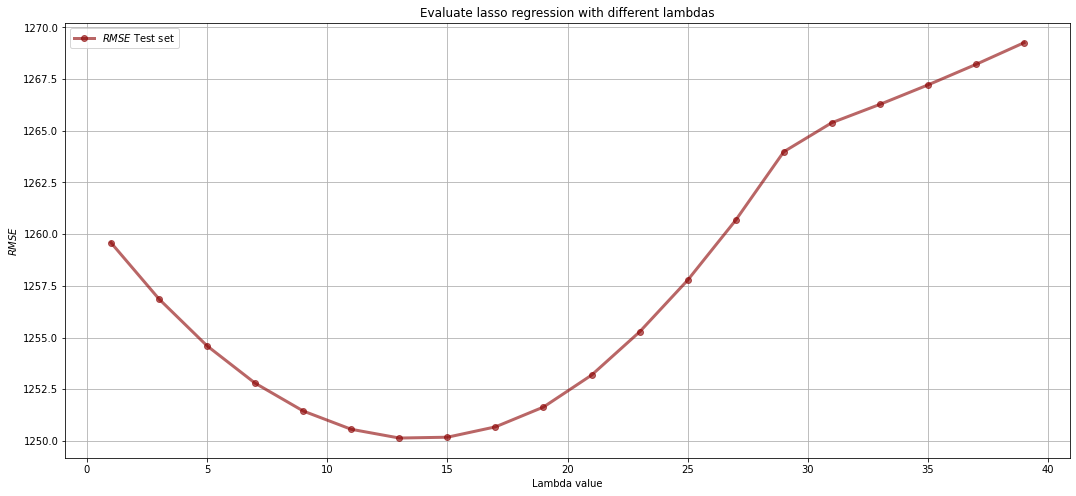

In [55]:
plt.figure(figsize=(18, 8))
plt.plot(lambdas,valid_RMSE, 'bo-', label=r'$RMSE$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lambda value'); plt.ylabel(r'$RMSE$')
#plt.xlim(0, 6)
plt.title(r'Evaluate lasso regression with different lambdas')
plt.legend(loc='best')
plt.grid()

In [44]:
car_lasso = Lasso(alpha = 13)
car_lasso.fit(train_X, train_y)
car_lasso.coef_

for ind, val in enumerate(car_lasso.coef_):  
    predvar = predictors[ind]
    print("The estimated coefficient for",predvar,"is",round(val,2))

The estimated coefficient for age_08_04 is -2358.8
The estimated coefficient for km is -624.17
The estimated coefficient for fuel_type_Petrol is 467.24
The estimated coefficient for fuel_type_Diesel is 762.1
The estimated coefficient for hp is 867.94
The estimated coefficient for met_color is 7.74
The estimated coefficient for automatic is 87.39
The estimated coefficient for cc is -631.48
The estimated coefficient for doors is 19.36
The estimated coefficient for quarterly_tax is 466.77
The estimated coefficient for weight is 841.14


Let's look at the "paths" of the coefficients as $\lambda$ increases. To do this, we take the following steps.
1. Set the list of $\lambda$s. Use a wider range to see when the coefficients are pushed down to zero.
2. Run the LASSO model for each of the $\lambda$ in the list. Save the coefficients generated from each fitted model
3. Create a plot of each of the coefficient estimates as a function of $\lambda$.

Notice how as $\lambda$ increases, the magnitude of more and more of the coefficients are pushed towards zero? By the time $\lambda$ is 100, only `age_08_04`, `hp`, `quarterly_tax`, `weight`, and `km` have non-zero coefficients. 

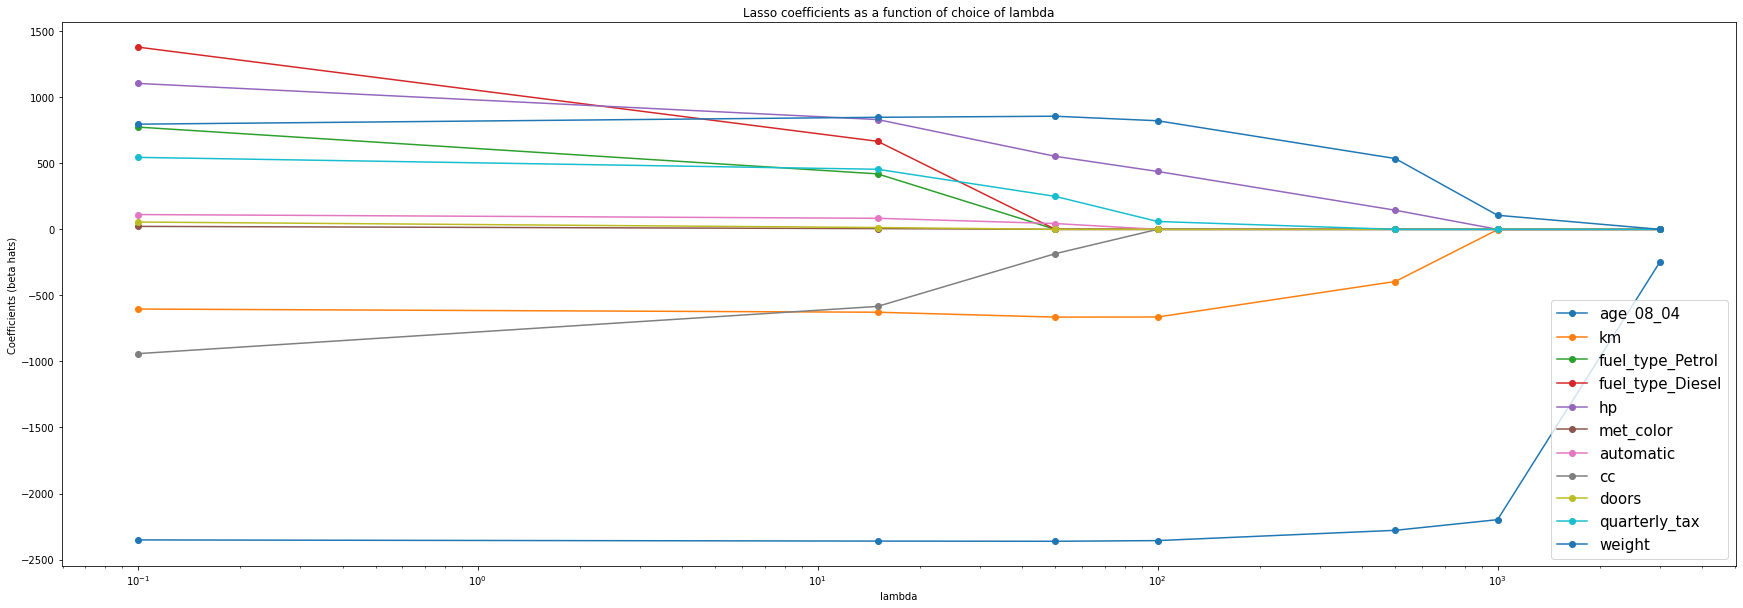

In [48]:
# Set lambdas
lambdas = [0.1,15,50,100,500,1000, 3000]

# Fit lasso regression for each lambda, save coefficients
coefs = []
for val in lambdas:
    car_lasso = Lasso(alpha = val)
    car_lasso.fit(train_X, train_y)
    coefs.append(car_lasso.coef_)
    
    
# Generate a plot
# Use log scale so that we can see it a little more easily
fig, ax = plt.subplots(figsize=(30, 10))

ax.plot(lambdas, coefs, marker="o")
ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('Coefficients (beta hats)')
plt.title('Lasso coefficients as a function of choice of lambda')
plt.axis('tight')
plt.legend(predictors,prop={'size': 15})

plt.show()